# **ExpLogic**

### **Setting up**

#### **Dependencies**

In [25]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import yaml
import os
import cv2
import time
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor, Compose, Lambda
import mnist_dataset
from hydra import initialize, compose
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from difflogic import LogicLayer, GroupSum, PackBitsTensor
from mnist_dataset import MNISTRemoveBorderTransform
import subset_loaders as subset

#### **Dataset**

Tunable Variables

In [32]:
# Configurable options
remove_border = True       # True: Removes border of Mnist, False: Keeps black border around digits
binarize_images = True     # True: Binarized Images, False: Grayscale Images 
evenly_partitioned = True  # True: Even distribution of samples, False: Original Mnist distribution
upscaled_images = False    # True: Upscales the samples to 32x32, False: Keeps size unchanged
downscaled_images = False   # True: Downscales the samples to 16x16, False: Keeps size unchanged
batch_size = 256           # Batch size

Set Seed for Reproducibiity

In [33]:
torch.manual_seed(42)      # PyTorch seed fixing
torch.cuda.manual_seed(42) # PyTorch CUDA seed fixing (if using GPU)
np.random.seed(42)         # NumPy seed fixing
random.seed(42)            # Python's built-in random seed fixing

Dataset Transform

In [34]:
# function to binarize an image, threshold is tunable 
def binarize(image, threshold=0.5):
    return (image > threshold).float()  

def binarize_transform(x):
    return binarize(x)

# define the transformation logic
transform_list = [ToTensor()]

# removes border around each mnist digit
if remove_border:
    transform_list.append(MNISTRemoveBorderTransform())

# upscales or downscales the images
if upscaled_images:
    transform_list.append(Resize((32, 32)))
elif downscaled_images:
    transform_list.append(Resize((16, 16)))

# binarizes the images
if binarize_images:
    transform_list.append(Lambda(binarize_transform))
    
transform = Compose(transform_list)

In [35]:
train_dataset = mnist_dataset.MNIST('./data-mnist', train=True, download=True, transform=transform)
test_dataset = mnist_dataset.MNIST('./data-mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

In [36]:
# makes the Dataset evenly partitioned
if evenly_partitioned:
    # code below is used so that all classes have the same number of samples
    train_targets = train_loader.dataset.targets
    test_targets = test_loader.dataset.targets

    train_digits_total = []
    test_digits_total = []

    for i in range(10):
        curr_tot_train = torch.sum(train_targets == i).item()
        curr_tot_test = torch.sum(test_targets == i).item()    
        train_digits_total.append(curr_tot_train)
        test_digits_total.append(curr_tot_test)

    train_digits_total, test_digits_total

    # find the minimum number of samples across all classes
    min_samples_train = min(train_digits_total)
    min_samples_test = min(test_digits_total)

    # function to trim dataset to match the minimum samples for each class and shuffle indices
    def trim_dataset(dataset, targets, min_samples):
        indices = []
        for i in range(10):
            class_indices = (targets == i).nonzero(as_tuple=True)[0]  # get indices of class i
            class_indices = class_indices[:min_samples]  # trim to min_samples
            indices.extend(class_indices)

        # shuffle indices after collecting them
        indices = torch.tensor(indices)
        indices = indices[torch.randperm(indices.size(0))]  

        return Subset(dataset, indices)

    # trim both train and test datasets to ensure all classes have the same number of samples
    trimmed_train_dataset = trim_dataset(train_loader.dataset, train_targets, min_samples_train)
    trimmed_test_dataset = trim_dataset(test_loader.dataset, test_targets, min_samples_test)

    # create DataLoaders for the trimmed datasets
    trimmed_train_loader = DataLoader(trimmed_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    trimmed_test_loader = DataLoader(trimmed_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

    # verify the lengths of the trimmed datasets
    len(trimmed_train_loader.dataset), len(trimmed_test_loader.dataset)

    train_dataset = trimmed_train_dataset
    test_dataset = trimmed_test_dataset
    train_loader = trimmed_train_loader
    test_loader = trimmed_test_loader

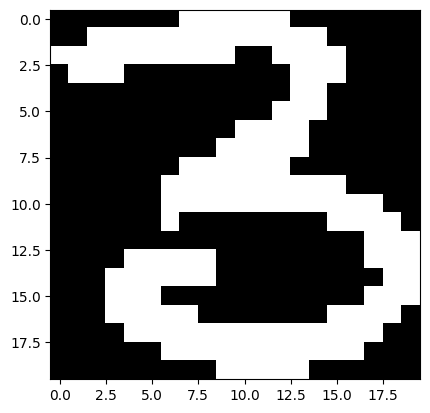

In [37]:
# visualizing a single image
dataset_size = len(train_dataset)
random_index = random.randint(0, dataset_size - 1)

if remove_border and not downscaled_images:
    image = train_loader.dataset[random_index][0].reshape(20, 20)
elif not remove_border and not upscaled_images and not downscaled_images:
    image = train_loader.dataset[random_index][0].reshape(28, 28)
elif downscaled_images:
    image = train_loader.dataset[random_index][0].reshape(16, 16)
else:
    image = train_loader.dataset[random_index][0].reshape(32, 32)
plt.imshow(image, cmap='gray')

#### Model Hyperparameters

Converts csv into yaml config file

In [38]:
# define first input and the name of the file to be saved
first_in_dim = 400 # 20x20
filename = "config/mnist_config_20x20.yaml"  

In [39]:
# reads the CSV file into a DataFrame
df = pd.read_csv("config/mnist_hyperparameters.csv")

# convert the DataFrame to a list of dictionaries
models = df.to_dict(orient="records")

# create the YAML structure
yaml_structure = {"models": {}}

# rounds the number to the nearest multiple of the output size
def round_to_nearest_multiple(value, multiple):
    return multiple * round(value / multiple)

# populate the YAML structure with models
for i, model in enumerate(models, start=1):
    # zero-padding model names to 3 digits 
    model_name = f"model_{str(i).zfill(3)}"
    layers_config = {}
    
    for layer in range(1, model["H"] + 1):
        # zero-padding the layer names to 3 digits
        layer_name = f"LogicLayer{str(layer).zfill(3)}"
        
        # adjusts in_dim to the nearest multiple of 10
        in_dim = first_in_dim if layer == 1 else round_to_nearest_multiple(model["W"], 10)
        
        # adjusts out_dim to the nearest multiple of 10
        out_dim = round_to_nearest_multiple(model["W"], 10)
        
        layers_config[layer_name] = {
            "in_dim": in_dim,
            "out_dim": out_dim,
            "device": "cuda",
            "implementation": "cuda",
            "connections": "random",
            "grad_factor": 2, # we can try different grad_factor values as well
        }
    
    yaml_structure["models"][model_name] = {
        "input_dim": first_in_dim, 
        "output_size": 10, # for MNIST classification
        "tau": model["tau"],
        "learning_rate": model["lr"],
        "layers_config": layers_config,
    }

# saves to a YAML file
with open(f'{filename}', "w") as file:
    yaml.dump(yaml_structure, file, default_flow_style=False)

print(f"YAML file '{filename}' generated successfully.")

YAML file 'config/mnist_config_20x20.yaml' generated successfully.


### **Model Definition**

#### **Model Function Declarations**

Custom GroupSum

In [40]:
class CustomGroupSum(GroupSum):
    """
    The CustomGroupSum module that extends GroupSum to include printing of class sums.
    """
    def forward(self, x):
        # Use the original functionality from GroupSum
        output = super().forward(x)

        # Calculate the class sums for printing
        if isinstance(x, PackBitsTensor):
            class_sums = x.group_sum(self.k)
        else:
            class_sums = x.reshape(*x.shape[:-1], self.k, x.shape[-1] // self.k).sum(-1)

        # Print the class sums before returning the output
        print("Class Sums:", class_sums)

        # Return the processed output, as in the original GroupSum
        return output

DiffLogic Class

In [41]:
class DiffLogic(nn.Module):
    def __init__(self, layers_config, output_size, tau=30):
        """
        Initializes the DiffLogic model with the specified layer configurations, output size, and temperature parameter.

        Args:
            layers_config (dict): Configuration for each logic layer, including dimensions, device, implementation, connections, and grad factor.
            output_size (int): The number of output groups (classes in a classification problem).
            tau (int): Temperature parameter for the GroupSum operation.
        """
        super(DiffLogic, self).__init__()
        self.flatten = nn.Flatten()
        
        # stores the logic layers
        layers = []
        for layer_name, config in layers_config.items():
            layer = LogicLayer(
                in_dim=config['in_dim'],
                out_dim=config['out_dim'],
                device=config['device'],
                implementation=config['implementation'],
                connections=config['connections'],
                grad_factor=config['grad_factor']       
            )
            layers.append(layer)
            print(layer)
        
        self.logic_layers = nn.Sequential(*layers)
        self.group = GroupSum(k=output_size, tau=tau)
        #self.group = CustomGroupSum(k=output_size, tau=tau) 
        self.log_text = ""  # initializes logging string

    def forward(self, x):
        """
        Forward pass of the DiffLogic model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the logic layers and grouping operation.
        """
        # moves tensor to GPU
        if torch.cuda.is_available():
            x = x.to('cuda')          
        x = self.flatten(x)
        logits = self.logic_layers(x)
        group = self.group(logits)
        return group
    
    def save(self, file_path, model_name='model'):
        """
        Saves the model's state dictionary to the specified file path.

        Args:
            file_path (str): Path where the model will be saved.
            model_name (str): Name of the saved model

        Returns:
            None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            'connections': [layer.indices for layer in self.logic_layers if isinstance(layer, LogicLayer)]
        }, os.path.join(file_path, f"{model_name}.pth"))
        self.log_text += f"Model saved to: {file_path}\n"

    def load(self, file_path):
        """
        Loads the model's state dictionary from the specified file path.

        Args:
            file_path (str): Path from which the model will be loaded.

        Returns:
            None
        """
        checkpoint = torch.load(file_path)
        self.load_state_dict(checkpoint['model_state_dict'])

        # assigns connections to each LogicLayer
        for idx, layer in enumerate(self.logic_layers):
            if isinstance(layer, LogicLayer):
                layer.indices = checkpoint['connections'][idx]

        self.eval()
        self.log_text += f"Model loaded from: {file_path}\n"
        
    def get_accuracy(self, data_loader):
        """
        Calculates the accuracy of the model against a data loader

        Args:
            data_loader: a DataLoader object, e.g. train_loader or test_loader

        Returns:
            float: The accuracy
        """
        correct = 0
        total = 0

        # ensures that model is in evaluation mode
        self.eval()

        with torch.no_grad():  # Disable gradient calculation for inference
            for batch_inputs, batch_outputs in tqdm(data_loader, desc="Running Inference"):
                batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

                # forward pass to get predictions
                outputs = self(batch_inputs)

                # gets the predicted class (index of the maximum logit)
                _, predicted = torch.max(outputs.data, 1)

                # counting correct predictions
                total += batch_outputs.size(0)  # total number of samples in the batch
                correct += (predicted == batch_outputs).sum().item()  # counting correct predictions

        accuracy = correct / total
        return accuracy

    def get_log(self):
        """
        Retrieves the log text and clears the log after retrieval.

        Returns:
            str: The log text.
        """
        log_copy = self.log_text
        self.log_text = ""  # Clear the log after returning
        return log_copy

In [42]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        """
        Initializes the EarlyStopper to stop training if the performance doesn't improve after a certain number of epochs.

        Args:
            patience (int): Number of epochs to wait for an improvement.
            min_delta (float): Minimum change to consider an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        """
        Check if training should stop based on the current loss.

        Args:
            current_loss (float): The current loss.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = current_loss
            return False
        elif current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            print("EarlyStopper Triggered: ", self.counter)
            if self.counter >= self.patience:
                return True
            return False

#### **Model Training**

In [ ]:
# initialize Hydra with the config path and job name
with initialize(version_base=None, config_path="config", job_name="ExpLogic"):
    cfg = compose(config_name="mnist_config_20x20")

# training loop for all models
all_models_dict = {}
num_epochs = 5
file_path = 'trained_models/mnist_trained_20x20' # where to save your trained models

# loops through all model configs and trains each of them
for model_name, model_cfg in cfg.models.items():
    print(f'training model {model_name}')

    # tracking dictionary
    all_models_dict[model_name] = {
        'losses': [],
    }

    try:
        # initializes DiffLogic model and moves to CUDA if available
        model = DiffLogic(layers_config=model_cfg['layers_config'], 
                          output_size=model_cfg['output_size'], 
                          tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        # optimizer and loss criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg['learning_rate'])
        criterion = nn.CrossEntropyLoss()
        
        # early stopping
        early_stopper = EarlyStopper(patience=5)

        for epoch in range(num_epochs):
            loop = tqdm(train_loader, leave=True, desc=f'Epoch {epoch+1}/{num_epochs}')
            epoch_loss = 0  # to track loss for an epoch
            
            for batch_inputs, batch_outputs in loop:
                # move data to the appropriate device
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
                batch_inputs, batch_outputs = batch_inputs.to(device).double(), batch_outputs.to(device).long()

                # forward pass through the model
                predictions = model(batch_inputs)
                loss = criterion(predictions, batch_outputs)

                # zero gradients, backpropagates, and updates model parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # accumulating the loss for the epoch
                epoch_loss += loss.item()

            # caclulating the average loss for the epoch
            epoch_loss /= len(train_loader)
            all_models_dict[model_name]['losses'].append(epoch_loss)
            print(f'Epoch {epoch+1} Loss: {epoch_loss}')

            # checks for early stopping
            if early_stopper.should_stop(epoch_loss):
                print(f"Early stopping triggered for {model_name} at epoch {epoch+1}.")
                break

        # saving trained model's state
        model.save(file_path, model_name)

    except Exception as e:
        print(f"ERROR TRAINING {model_name.upper()}: {str(e)}")

print("All models processed.")

#### **Model Testing**

In [43]:
# testing loop to test inferences
trained_models_dir = 'trained_models/'

# retrieves a list of all model files in the directory
model_files = sorted([f for f in os.listdir(trained_models_dir) if f.endswith('.pth')])

with initialize(version_base=None, config_path="config", job_name="ExpLogic_Test"):
    cfg = compose(config_name="mnist_config_20x20")

# dictionary to store the trained models
trained_models = {}
trained_models_accuracies = {}

# loops through all model files and calculates their accuracies
for i, model_file in enumerate(model_files):
    if model_file.endswith('_weights.pth'):
        model_name = model_file.removesuffix('_weights.pth')
    else:
        model_name = model_file.removesuffix('.pth')
    
    model_cfg = cfg['models'][model_name]
    
    # instantiates the model and load its weights
    model = DiffLogic(layers_config=model_cfg['layers_config'], 
                          output_size=model_cfg['output_size'], 
                          tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')
    
    model_path = os.path.join(trained_models_dir, model_file)
    print(f"Evaluating {model_file}...")

    # loads the respective model
    model.load(model_path)
    
    # calculates accuracy
    accuracy = model.get_accuracy(test_loader)
    
    print(f"Accuracy of {model_file}: {accuracy * 100:.2f}%\n")
    
    trained_models[i] = model
    trained_models_accuracies[i] = accuracy

LogicLayer(400, 2500, train)
LogicLayer(2500, 2500, train)
Evaluating model_077_weights.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 13.28it/s]

Accuracy of model_077_weights.pth: 92.15%



### **Switching Probability**

Converting DiffLogic to LogicGraph

In [44]:
from LogicGraph import * 
    
print("Creating LogicGraph")
gall = LogicGraph(model)

gall.compute_sf(train_loader)
gall.compute_sp(np.ones((20,20))-0.5)

gall.edges()[('L1_N2029', 'L2_N2124')]["ab"]

Creating LogicGraph


Processing MNIST images: 100%|██████████| 211/211 [00:20<00:00, 10.41it/s]


'b'

#### **Difference of SP for Individual Classes**

Find the TP, TN, FP, FN instances, and use this to create sub-datasets for specific cases 

In [46]:
# set to True if you have already created the files
saved = False 

In [47]:
def binarize(image, threshold=0.5):
    return (image > threshold).float()

def predict_and_categorize(model, data_loader, binary=False, threshold=0.5):
    all_images = []
    all_labels = []
    all_predictions = []

    # Ensure model is in evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_inputs, batch_outputs in tqdm(data_loader, desc="Predicting"):
            batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

            if binary:
                batch_inputs = binarize(batch_inputs)

            # Forward pass to get predictions
            outputs = model(batch_inputs)

            # Get the predicted class (index of the maximum logit)
            _, predicted = torch.max(outputs.data, 1)

            all_images.append(batch_inputs.cpu())
            all_labels.append(batch_outputs.cpu())
            all_predictions.append(predicted.cpu())

    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)

    return all_images, all_labels, all_predictions

if not saved: 
    # Usage:
    binary = True    # Set to True if you want to binarize the images
    threshold = 0.5  # Set the threshold for binarization if binarize is True

    all_images_train, all_labels_train, all_predictions_train = predict_and_categorize(model, train_loader, binary=binary, threshold=threshold)
    all_images_test,  all_labels_test,  all_predictions_test  = predict_and_categorize(model,  test_loader, binary=binary, threshold=threshold) 

    torch.save(     all_images_train, 'datasets/all_images_train.pth')
    torch.save(     all_labels_train, 'datasets/all_labels_train.pth')
    torch.save(all_predictions_train, 'datasets/all_predictions_train.pth')

    torch.save(     all_images_test, 'datasets/all_images_test.pth')
    torch.save(     all_labels_test, 'datasets/all_labels_test.pth')
    torch.save(all_predictions_test, 'datasets/all_predictions_test.pth')

else: 
    all_images_train      = torch.load('datasets/all_images_train.pth')
    all_labels_train      = torch.load('datasets/all_labels_train.pth')
    all_predictions_train = torch.load('datasets/all_predictions_train.pth')

    all_images_test       = torch.load('datasets/all_images_test.pth')
    all_labels_test       = torch.load('datasets/all_labels_test.pth')
    all_predictions_test  = torch.load('datasets/all_predictions_test.pth')

if not saved: 
    # Fix random seeds for reproducibility
    torch.manual_seed(42)            
    torch.cuda.manual_seed(42)        
    np.random.seed(42)
    # If using CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Init parameters
    batch_size = 256   # this can be tuned as well 
    binary   = True    # Set this to True if you want to binarize the images
    threshold  = 0.5   # Set the threshold for binarization

    # Create class-specific data loaders for training and testing sets
    train_class_loaders = subset.create_class_dataloaders(train_dataset, batch_size, binarize=binary, threshold=threshold)
    test_class_loaders  = subset.create_class_dataloaders(test_dataset,  batch_size, binarize=binary, threshold=threshold)

    print("Saving the Class Datasets")
    torch.save(train_class_loaders, 'datasets/train_class_loaders.pth')
    torch.save(test_class_loaders, 'datasets/test_class_loaders.pth')

    # Create TN/TP/FN/FP datasets
    general_datasets        = subset.create_tn_tp_fn_fp_datasets(all_images_train, all_labels_train, all_predictions_train)
    class_specific_datasets = subset.create_class_specific_datasets(all_images_train, all_labels_train, all_predictions_train)

    print("Saving the General Datasets")
    torch.save(general_datasets, 'datasets/general_datasets.pth')

    # For the general TN, TP, FN, FP datasets:
    t_dataset = DataLoader(general_datasets['T'],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    f_dataset = DataLoader(general_datasets['F'],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

    print("Saving the General Datasets")
    torch.save(t_dataset, 'datasets/t_dataset.pth')
    torch.save(f_dataset, 'datasets/f_dataset.pth')

    # For class-specific datasets (e.g., for class 5):
    print("Saving the Class-Specific Datasets")
    for i in range(10): 
        class_specific_datasets['TP_class'][i] = DataLoader(class_specific_datasets['TP_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
        class_specific_datasets['FP_class'][i] = DataLoader(class_specific_datasets['FP_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
        class_specific_datasets['TN_class'][i] = DataLoader(class_specific_datasets['TN_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
        class_specific_datasets['FN_class'][i] = DataLoader(class_specific_datasets['FN_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

    torch.save(class_specific_datasets, 'datasets/class_specific_datasets.pth')    
else: 
    t_dataset               = torch.load('datasets/t_dataset.pth')
    f_dataset               = torch.load('datasets/f_dataset.pth')
    class_specific_datasets = torch.load('datasets/class_specific_datasets.pth')
    train_class_loaders     = torch.load('datasets/train_class_loaders.pth')
    test_class_loaders      = torch.load('datasets/test_class_loaders.pth')
    general_datasets        = torch.load('datasets/general_datasets.pth')

Predicting: 100%|██████████| 34/34 [00:01<00:00, 20.57it/s]


Saving the Class Datasets
Saving the General Datasets
Saving the General Datasets
Saving the Class-Specific Datasets


Class Specific Differences

In [48]:
outputs = [f"L3_N0", f"L3_N1", f"L3_N2", f"L3_N3", f"L3_N4", f"L3_N5", f"L3_N6", f"L3_N7", f"L3_N8", f"L3_N9"]

p_maps = []
sp_graphs = [] 
sp_diffs = [] 
for j, output_node in enumerate(outputs): 
    p_maps.append(cv2.imread(f"mnist_averages/average_digit_{j}.png")[4:24,4:24,1]/255)
    sp_graph  = copy.deepcopy(gall)
    sp_graph.compute_sp(p_maps[j])
    sp_graphs.append(sp_graph)
    sp_diffs.append(sp_graph.sub_sp(gall))
    
# Compute SF for each graph
graphs = {}
for g in range(10): 
    print(f"Class {g}")
    graphs[g] = LogicGraph(model)
    graphs[g].compute_sf(train_class_loaders[g])

Class 0


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00, 10.44it/s]


Class 1


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00,  9.81it/s]


Class 2


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00, 10.44it/s]


Class 3


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00, 10.32it/s]


Class 4


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00,  9.39it/s]


Class 5


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00, 10.42it/s]


Class 6


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00, 10.29it/s]


Class 7


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00, 10.30it/s]


Class 8


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00, 10.27it/s]


Class 9


Processing MNIST images: 100%|██████████| 21/21 [00:02<00:00, 10.17it/s]


In [49]:
# Compute SF for each graph
fps = {}
tps = {}
fns = {}
tns = {}
for g in range(10): 
    print(g)
    fps[g] = LogicGraph(model)
    if [i for i in class_specific_datasets['FP_class'][g]] != []:
        fps[g].compute_sf(class_specific_datasets['FP_class'][g])
    #tps[g] = LogicGraph(model)
    #if [i for i in class_specific_datasets['TP_class'][g]] != []:
    #    tps[g].compute_sf(class_specific_datasets['TP_class'][g])
    fns[g] = LogicGraph(model)
    if [i for i in class_specific_datasets['FN_class'][g]] != []:
        fns[g].compute_sf(class_specific_datasets['FN_class'][g])
    tns[g] = LogicGraph(model)
    if [i for i in class_specific_datasets['TN_class'][g]] != []:
        tns[g].compute_sf(class_specific_datasets['TN_class'][g])

0


Processing MNIST images: 100%|██████████| 188/188 [00:09<00:00, 19.90it/s]


1


Processing MNIST images: 100%|██████████| 188/188 [00:09<00:00, 19.83it/s]


2


Processing MNIST images: 100%|██████████| 188/188 [00:09<00:00, 19.80it/s]


3


Processing MNIST images: 100%|██████████| 187/187 [00:09<00:00, 19.75it/s]


4


Processing MNIST images: 100%|██████████| 187/187 [00:09<00:00, 19.78it/s]


5


Processing MNIST images: 100%|██████████| 187/187 [00:09<00:00, 19.75it/s]


6


Processing MNIST images: 100%|██████████| 188/188 [00:09<00:00, 19.72it/s]


7


Processing MNIST images: 100%|██████████| 188/188 [00:09<00:00, 19.54it/s]


8


Processing MNIST images: 100%|██████████| 188/188 [00:09<00:00, 20.41it/s]


9


Processing MNIST images: 100%|██████████| 187/187 [00:09<00:00, 20.35it/s]


In [50]:
# Compute SF Diff for each combination
print("Computing diffs")
diffs = {}
for i in range(10): 
    diff = {} 
    for j in range(10): 
        diff[j] = graphs[i] - graphs[j]
    diffs[i] = diff

print("Computing centered")
centered = {}
for i in range(10): 
    centered[i] = graphs[i] - gall
    
print("Computing specific")
specific = {}
for i in range(10): 
    specific[i] = graphs[i] - tns[i]    

Computing diffs
Computing centered
Computing specific


Plot the Differences in the switching frequency per Class Prediction

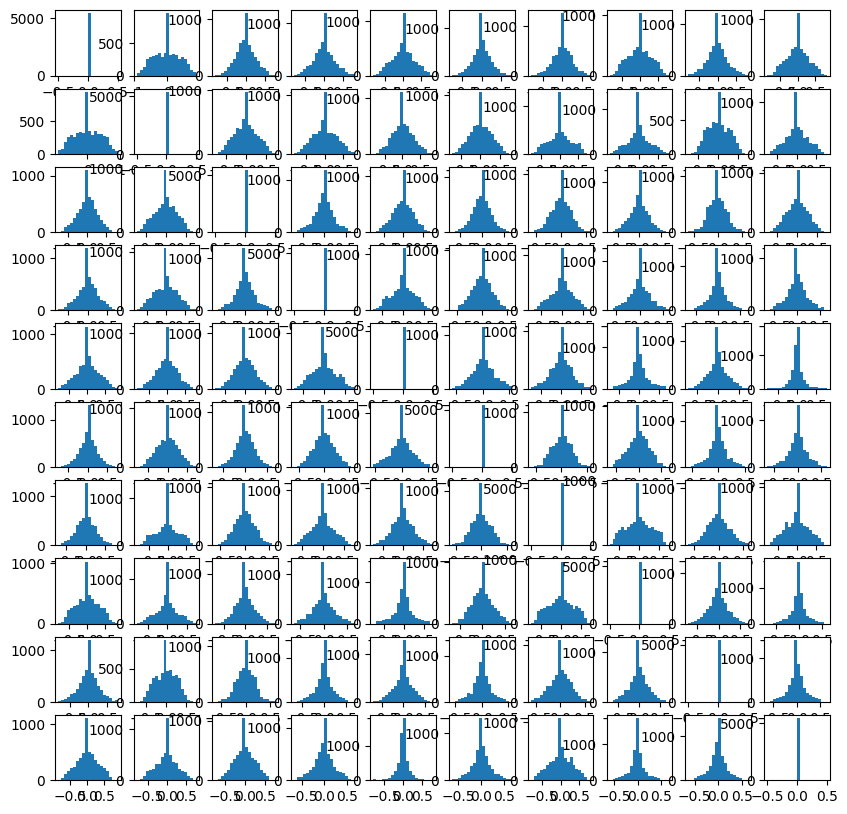

In [51]:
fig, ax = plt.subplots(10,10,figsize=(10,10))
for i in range(10): 
    for j in range(10): 
        sf = list(nx.get_node_attributes(diffs[i][j].g,"sf").values())
        ax[i][j].hist(sf,bins=20)

Initialize helper functions for visualizing the FAN-IN

In [55]:
a_not_list = ["not_implied_by", "not_or","not_xor","not_a","implies","not_and"]
b_not_list = ["not_implies", "not_or","not_xor","not_b","implied_by","not_and"]

def find_fan_in(G, output_node, threshold,metric="sf"):
    """
    Find all input nodes connected to the given output node.
    """
    fan_in = set()
    nodes_to_check = [(output_node,1)]
    input_set = []
    while nodes_to_check:
        
        # Get node and node properties 
        parent_node, dpo = nodes_to_check.pop(0)
        new_fan_in  = []
        child_gates = []
        parent_type = G.nodes[parent_node]["gate"]
        
        # Account for all predesesors
        for child_node in list(G.predecessors(parent_node)): 
            
            desired_parent_output = dpo*1
            
            # Get type of child node 
            child_type = G.nodes[child_node]["gate"]
            
            # Account for output case 
            if parent_type == "output": 

                # Check whether the current node is contributing to the class output
                desired_child_output = desired_parent_output
                if G.nodes[child_node][metric] > threshold: 
                    child_gates.append((child_node, desired_child_output))
                    new_fan_in.append((child_node,  desired_child_output))

            # Account for hidden-layer case 
            elif child_node != "input": 

                # Get the current wire type
                props     = G.get_edge_data(child_node, parent_node)
                wire_type = props["ab"] if "ab" in props.keys() else None

                # Check whether the current wire increases the class score by being zero
                if (wire_type == "a" and parent_type in a_not_list) or (wire_type == "b" and parent_type in b_not_list): 
                    
                    # Adjust the "desired child output"
                    desired_child_output = -desired_parent_output
                    
                    # Check whether the current node is contributing to the class output
                    if G.nodes[child_node][metric] <= threshold: # Less than because we contribute by being a zero 
                        child_gates.append((child_node,desired_child_output))
                        new_fan_in.append((child_node,desired_child_output))
                    
                # Case where the current wire increases the class score by being a one
                else: 
                    
                    # Adjust the "desired child output"
                    desired_child_output = desired_parent_output
                    
                    # Check whether the current node is contributing to the class output
                    if G.nodes[child_node][metric] > threshold: 
                        child_gates.append((child_node,desired_child_output))
                        new_fan_in.append((child_node,desired_child_output))

            # Account for input case
            else: 
                
                # Get the current wire type
                props = G.get_edge_data(child_node, parent_node)
                wire_type = props["ab"] if "ab" in props.keys() else None

                # Check whether the current wire increases the class score by being zero
                if (wire_type == "a" and parent_type in a_not_list) or (wire_type == "b" and parent_type in b_not_list): 
                    
                    # Adjust the "desired child output"
                    child_sign = -1*parent_sign
                    new_fan_in.append(  (child_node, child_sign))
                    input_set.append( (child_node, child_sign))
                    
                # Case where the current wire increases the class score by being a one
                else: 
                    
                    # Adjust the "desired child output"
                    child_sign = parent_sign
                    new_fan_in.append(  (child_node, child_sign))
                    input_set.append( (child_node, child_sign))
                        
        fan_in.update(new_fan_in)
        nodes_to_check.extend(child_gates)

    return fan_in, input_set

def node_to_pixel(node_id):
    """
    Convert a node ID (e.g., 'L0_Gate 1') to pixel coordinates.
    Assumes the input layer corresponds to a 28x28 image (MNIST format).
    """
    if (node_id != "HIGH") and (node_id != "LOW"): 
        layer, gate = node_id.split('_')
        
        gate_num = int(gate.split("N")[1]) - 1  # Convert 'Gate X' to zero-based index

        if layer == 'L0':  # Input layer
            y = gate_num // 20
            x = gate_num % 20
            return (x, y)
        
    return None  # For non-input layers, return None

def visualize_fan_in(G, output_node,threshold,signed=True, show=False,metric="sf"):
    """
    Visualize the fan-in of the given output node as highlighted pixels in an image.
    """
    fan_in,pixels = find_fan_in(G, output_node,threshold,metric)
    # Create a blank 28x28 image
    img = np.zeros((20, 20))
    
    # Highlight pixels corresponding to input nodes in the fan-in
    for node,sign in fan_in:
        pixel = node_to_pixel(node)
        if pixel:
            x, y = pixel
            if signed: 
                img[y, x] += sign  # Set pixel to white (1)
            else: 
                img[y, x] += 1  # Set pixel to white (1)

    if show: 
        # Plot the image
        plt.imshow(img)
        plt.title(f"Fan-in visualization for {output_node}")
        plt.colorbar()
        plt.axis('off')
        plt.show()
    
    return img, fan_in,pixels

Visualize the saliency maps for the FAN-IN (Class specific SF, and Global SF)

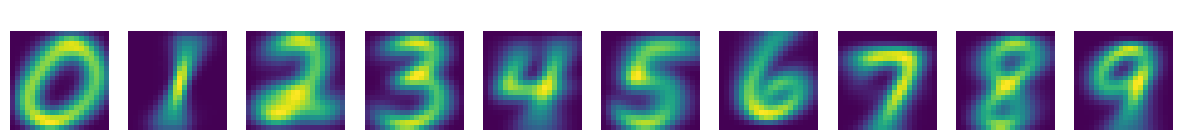

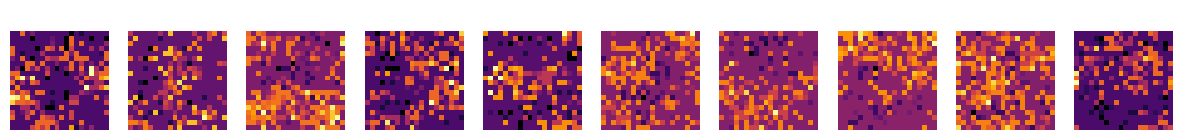

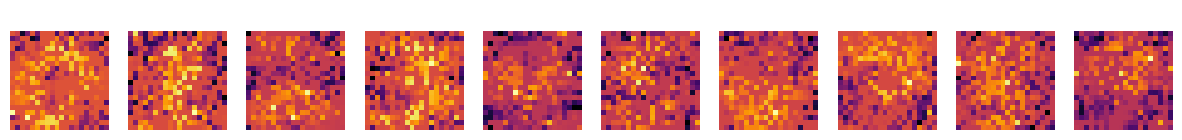

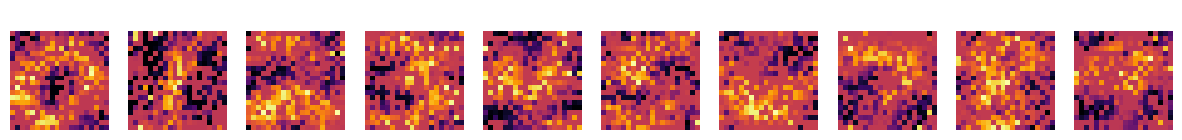

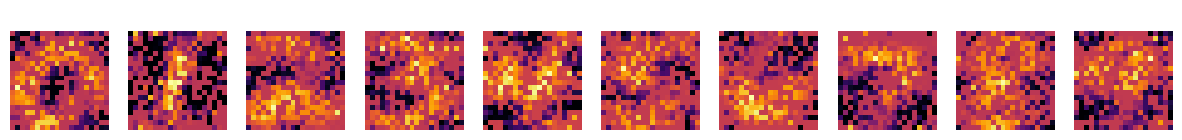

In [ ]:
thresholds = [float(i)/100-1.0 for i in range(200)]
#thresholds = [0.0]
outputs = [f"L3_N0", f"L3_N1", f"L3_N2", f"L3_N3", f"L3_N4", f"L3_N5", f"L3_N6", f"L3_N7", f"L3_N8", f"L3_N9"]
test = False


def plot_row(g,thresholds,signed,metric): 
    # Plot pixel attribution  
    fig, ax = plt.subplots(1, len(outputs), figsize=(15, 10))
    for i, output_node in enumerate(outputs): 
        G = g[i].g
        im = []
        for threshold in thresholds: 
            img, fan_in,pixels = visualize_fan_in(G, output_node, threshold,signed, False,metric)
            im.append(img)
        img  = np.average(im,axis=0)
        ax[i].imshow(img,cmap="inferno")
        ax[i].title.set_text(" ")#(f"{i}")
        ax[i].set_axis_off()
    plt.show()
    
print("#################################################### MNIST ####################################################")if test else None 
import copy 
fig, ax = plt.subplots(1, len(outputs), figsize=(15, 10))
p_maps = []
sp_graphs = [] 
sp_diffs = [] 
for j, output_node in enumerate(outputs): 
    p_maps.append(cv2.imread(f"mnist_averages/average_digit_{j}.png")[4:24,4:24,1]/255)
    sp_graph  = copy.deepcopy(gall)
    sp_graph.compute_sp(p_maps[j])
    sp_graphs.append(sp_graph)
    sp_diffs.append(sp_graph.sub_sp(gall))
    ax[j].imshow(p_maps[j])
    ax[j].title.set_text(" ")#(f"{j}")
    ax[j].set_axis_off()
plt.show()
#burn = cv2.imread(f"mnist_averages/average_all_digits.png")
#ax[len(outputs)].imshow(burn[4:24,4:24,1])


t1 = [float(i)/100 for i in range(100)]
t2 = [float(i)/100-0.5 for i in range(100)]


print("#################################################### Switch Probability ####################################################")if test else None 

print("--- Uniform 0.5") if test else None 
gall.compute_sp(np.ones((20,20))-0.5)
plot_row([gall for i in range(len(graphs))],t1,True,"sp")

print("--- Average of All MNIST Digits") if test else None 
p_maps.append(cv2.imread(f"mnist_averages/average_all_digits.png")[4:24,4:24,1]/255)
gall.compute_sp(p_maps[-1])
plot_row([gall for i in range(len(graphs))],t1,True,"sp")

print("--- Average of Class-Specific MNIST Digits") if test else None 
plot_row(sp_graphs,t1,True,"sp")

print("--- (Class-Specific-Average) - (Global-Average)") if test else None 
plot_row(sp_diffs,t2,True,"sp")

print("#################################################### Switch Frequency ####################################################")if test else None 

fig, ax = plt.subplots(1, len(outputs), figsize=(15, 10))
p_maps = []
sp_graphs = [] 
sp_diffs = [] 
for j, output_node in enumerate(outputs): 
    p_maps.append(cv2.imread(f"mnist_averages/average_digit_{j}.png")[4:24,4:24,1]/255)
    sp_graph  = copy.deepcopy(gall)
    sp_graph.compute_sp(p_maps[j])
    sp_graphs.append(sp_graph)
    sp_diffs.append(sp_graph.sub_sp(gall))
    ax[j].imshow(p_maps[j])
    ax[j].title.set_text(" ")#(f"{j}")
    ax[j].set_axis_off()
plt.show()

#print("--- Raw Association") if test else None 
#plot_row(graphs,[-1],False,"sf")

print("--- (Signed Association)") if test else None 
plot_row(graphs,[-1,0],True,"sf")

print("--- (All MNIST)") if test else None 
plot_row([gall for i in range(len(graphs))],t1,True,"sf")

print("--- (Class-Specific)") if test else None 
plot_row(graphs,t1,True,"sf")

print("--- (Class-Specific) - (All MNIST)") if test else None 
plot_row(specific,t2,True,"sf")

Show and generate local explanations

In [ ]:
test = nx.get_node_attributes(g.g,"sf")
t = [test[i] for i in nx.get_node_attributes(g.g,"sf").keys()]

In [28]:
# Switching Frequency
for k,(data,label) in enumerate(class_specific_datasets['FN_class'][8].dataset): 
    g = LogicGraph(model)
    g.compute_sf(data)
    
    fig, ax = plt.subplots(1, len(outputs)+1, figsize=(15, 10))
    thresholds = [0.5]
    for i, output_node in enumerate(outputs): 
        im = []
        for threshold in thresholds: 
            img, fan_in,pixels = visualize_fan_in(g.g, output_node, threshold,True,False)
            im.append(img)

        img  = np.average(im,axis=0)
        overlap = np.array(img==(data*2-1).cpu().detach().numpy()).astype(int)
        
        ax[i].imshow((img*overlap).reshape((20,20,1)))
        ax[i].title.set_text(f"{i}-{np.sum(np.abs(img))}")
    ax[len(outputs)].imshow(data.reshape((20,20,1)))
    ax[len(outputs)].title.set_text(f"{np.argmax(np.array(g.forward(data).cpu().detach()))}")
    plt.show()
    
    if k > 5: 
        break 

NameError: name 'class_specific_datasets' is not defined

In [27]:
# Switching Probability
for k,(data,label) in enumerate(class_specific_datasets['FN_class'][8].dataset): 
    g = LogicGraph(model)
    g.compute_sp(data)
    
    fig, ax = plt.subplots(1, len(outputs)+1, figsize=(15, 10))
    thresholds = [0]
    for i, output_node in enumerate(outputs): 
        im = []
        for threshold in thresholds: 
            img, fan_in,pixels = visualize_fan_in(g.g, output_node, threshold,True,False,metric="sp")
            im.append(img)

        img  = np.average(im,axis=0)
        overlap = np.array(img==(data*2-1).cpu().detach().numpy()).astype(int)
        
        ax[i].imshow((img*overlap).reshape((20,20,1)))
        ax[i].title.set_text(f"{i}-{np.sum(np.abs(img))}")
    ax[len(outputs)].imshow(data.reshape((20,20,1)))
    ax[len(outputs)].title.set_text(f"{np.argmax(np.array(g.forward(data).cpu().detach()))}")
    plt.show()
    
    if k > 5: 
        break 

NameError: name 'class_specific_datasets' is not defined

In [29]:
test = True
for k,(data,label) in enumerate(train_loader.dataset): 
    g = LogicGraph(model.diff_logic_model)
    g.compute_sf(data)
    
    fig, ax = plt.subplots(1, len(outputs)+1, figsize=(15, 10))
    thresholds = [0.0]
    for i, output_node in enumerate(outputs): 
        im = []
        for threshold in thresholds: 
            img, fan_in,pixels = visualize_fan_in(g.g, output_node, threshold,True,False,test)
            im.append(img)

        img  = np.average(im,axis=0)
        overlap = np.array(img==(data*2-1).cpu().detach().numpy()).astype(int)
        
        ax[i].imshow((img*overlap).reshape((20,20,1)))
        ax[i].title.set_text(f"{i}-{np.sum(np.abs(img))}")
    ax[len(outputs)].imshow(data.reshape((20,20,1)))
    ax[len(outputs)].title.set_text(f"{np.argmax(np.array(g.forward(data).cpu().detach()))}")
    plt.show()
    
    if k > 5: 
        break 

AttributeError: 'DiffLogic' object has no attribute 'diff_logic_model'

In [30]:
class_specific_datasets['FP_class'][index].dataset

NameError: name 'class_specific_datasets' is not defined

In [31]:
from matplotlib import rc

index = 1

for k,(data,label) in enumerate(class_specific_datasets['TP_class'][index].dataset): 
    g = LogicGraph(model)
    g.compute_sf(data)
    
    fig, ax = plt.subplots(1, len(outputs)+1, figsize=(15, 10))
    thresholds = [0.0]
    for i, output_node in enumerate(outputs): 
        im = []
        for threshold in thresholds: 
            img, fan_in,pixels = visualize_fan_in(g.g, output_node, threshold,True,False)
            im.append(img)

        img  = np.average(im,axis=0)
        overlap = np.array(img==(data*2-1).cpu().detach().numpy()).astype(int)
        
        ax[i+1].imshow((img*overlap).reshape((20,20,1)),"inferno",vmin=-1,vmax=1)
        ax[i+1].title.set_text(f"C: {i}; $\Sigma$={int(np.sum(np.abs(img)*overlap))}")
        
        ax[i+1].set_axis_off()
        
    ax[0].imshow(data.reshape((20,20,1)),"inferno")
    ax[0].title.set_text(f"C: {np.argmax(np.array(g.forward(data).cpu().detach()))} (TP)")
    ax[0].set_axis_off()
    plt.show()
    
    break 
        
for k,(data,label) in enumerate(class_specific_datasets['FP_class'][index].dataset): 
    g = LogicGraph(model)
    g.compute_sf(data)
    
    fig, ax = plt.subplots(1, len(outputs)+1, figsize=(15, 10))
    thresholds = [0.0]
    for i, output_node in enumerate(outputs): 
        im = []
        for threshold in thresholds: 
            img, fan_in,pixels = visualize_fan_in(g.g, output_node, threshold,True,False)
            im.append(img)

        img  = np.average(im,axis=0)
        overlap = np.array(img==(data*2-1).cpu().detach().numpy()).astype(int)
        
        ax[i+1].imshow((img*overlap).reshape((20,20,1)),"inferno",vmin=-1,vmax=1)
        ax[i+1].title.set_text(f"C: {i}; $\Sigma$={int(np.sum(np.abs(img)*overlap))}")
        
        ax[i+1].set_axis_off()
        
    ax[0].imshow(data.reshape((20,20,1)),"inferno")
    ax[0].title.set_text(f"C: {np.argmax(np.array(g.forward(data).cpu().detach()))} (FP)")
    ax[0].set_axis_off()
    plt.show()
    
    break 
    
        
for k,(data,label) in enumerate(class_specific_datasets['FN_class'][index].dataset): 
    g = LogicGraph(model)
    g.compute_sf(data)
    
    fig, ax = plt.subplots(1, len(outputs)+1, figsize=(15, 10))
    thresholds = [0.0]
    for i, output_node in enumerate(outputs): 
        im = []
        for threshold in thresholds: 
            img, fan_in,pixels = visualize_fan_in(g.g, output_node, threshold,True,False)
            im.append(img)

        img  = np.average(im,axis=0)
        overlap = np.array(img==(data*2-1).cpu().detach().numpy()).astype(int)
        
        ax[i+1].imshow((img*overlap).reshape((20,20,1)),"inferno")
        ax[i+1].title.set_text(f"C: {i}; $\Sigma$={int(np.sum(np.abs(img*overlap)))}")
        
        ax[i+1].set_axis_off()
        
    ax[0].imshow(data.reshape((20,20,1)),"inferno")
    ax[0].title.set_text(f"C: {np.argmax(np.array(g.forward(data).cpu().detach()))} (FN)")
    ax[0].set_axis_off()
    plt.show()
    
    break     

NameError: name 'class_specific_datasets' is not defined

#### **Regions associated with FN and FP cases**

### **Further Analysis**

#### **Data Loading**

In [54]:
# Create outputs directory if it doesn't exist
if not os.path.exists("./outputs"):
    os.mkdir("./outputs")

# Read and concatenate CSVs in ./outputs
df_list = []
folder = "./outputs/"
for file in os.listdir(folder):
    if file.endswith(".csv"):
        df_list.append(pd.read_csv(os.path.join(folder, file)))

if df_list:
    dfs = pd.concat(df_list).reset_index(drop=True)
else:
    print("No CSV files found to concatenate.")

No CSV files found to concatenate.


#### **Histogram Plotting & Statistics**

In [ ]:
# Set up histogram parameters
step_size = 0.25
max_num   = 20
bins      = [i * step_size for i in range(int(max_num/step_size))]
alpha_val = 0.5

# Example sets of dtypes, labels, and legends
dtypes = ["ri", "rip", "rin"]
labels = ["+/- Imp.", "+ Imp.", "- Imp."]
legend = ["rand", "ig", "vg", "dl", "lsp", "lsp"]

Function Definitions

In [ ]:
# Stripe plot with 'inferno' colormap
def plt_stripe(dtype, datas, bins, alpha, titles, legend, label):
    fig, ax = plt.subplots(1, 1, figsize=(15, 2))
    colormap = plt.cm.inferno
    num_colors = len(datas)
    
    for i, (data, title) in enumerate(zip(datas, titles)):
        # Filter out zeros (if needed)
        data = [d for d in data if d != 0]
        color = colormap(i / num_colors)  # pick color from colormap
        ax.hist(data, bins=bins, alpha=alpha, color=color, label=title)
    
    ax.set_title(label)
    ax.set_xlabel("Distance Traveled (L2)")
    ax.set_ylabel("Counts")
    ax.legend(legend)

# Calculate statistics (mean, std, etc.)
def calculate_statistics(datas, titles, label):
    stats = []
    for data, title in zip(datas, titles):
        # Count and filter
        zeros  = [d for d in data if d == 0]
        larges = [d for d in data if d > 50]
        data   = [d for d in data if (d != 0) and (d < 100)]
        
        # Compute
        mean_val = np.mean(data) if len(data) > 0 else np.nan
        std_val  = np.std(data)  if len(data) > 0 else np.nan
        num_large = len(larges)
        num_zeros = len(zeros)
        num_valid = len(data)
        total     = num_large + num_zeros + num_valid
        pct_valid = (num_valid / total * 100) if total else np.nan
        
        stats.append([
            label, title, mean_val, std_val, 
            num_large, num_zeros, num_valid, pct_valid
        ])
    return stats

Collecting and Displaying Stats

In [ ]:
# Collect stats across different dtypes
all_stats = []
for dt, lbl in zip(dtypes, labels):
    # Titles to collect from the DataFrame
    titles = [
        f"ig_d_r3",
        f"ig_d_{dt}",
        f"vg_d_{dt}",
        f"dl_l_sf_d_{dt}",
        f"dl_g_sf_d_{dt}",
        f"dl_c_sf_d_{dt}",
        f"dl_s_sf_d_{dt}",
        f"dl_l_sp_d_{dt}",
        f"dl_g_sp_d_{dt}",
        f"dl_c_sp_d_{dt}",
        f"dl_s_sp_d_{dt}",
        f"dl_z_sp_d_{dt}",
    ]
    data = [dfs[t] for t in titles if t in dfs.columns]
    all_stats.extend(calculate_statistics(data, titles, lbl))
    plt_stripe(dt, data, bins, alpha_val, titles, legend, lbl)

# Create a DataFrame of statistics and display
columns = [
    "Comparison Type", "Data Type", "Mean", "Standard Deviation",
    "# DNC", "# Zeros", "# Valid", "% Valid"
]
df_stats = pd.DataFrame(all_stats, columns=columns)
print(df_stats)

#### **ImageConversion & Side-by-Side Display**

In [ ]:
# Helper function to convert a string representation of a 2D array into a NumPy array
def convert_to_array(string, shape=(20, 20)):
    """
    Cleans and converts a string like '[1 2 3 ...]' 
    into a NumPy array with given shape.
    """
    cleaned = string.strip('[]').replace('\n', ' ')
    split_vals = cleaned.split()
    float_vals = [float(v) for v in split_vals]
    return np.array(float_vals).reshape(shape)

# Example: Display several images side by side
# (Assume columns 'image', 'vg_s', 'dl_c_sf_s', etc. exist in dfs)

cols_to_show = ["image", "vg_s", "dl_c_sf_s", "dl_g_sf_s", "ig_s"]
num_images = len(cols_to_show)
fig, axes = plt.subplots(1, num_images, figsize=(12, 2))

for i, col in enumerate(cols_to_show):
    if col in dfs.columns:
        arr = convert_to_array(dfs[col].iloc[0])
        axes[i].imshow(arr, cmap='inferno')
        axes[i].set_title(col)
        axes[i].axis("off")

plt.tight_layout()
plt.show()

#### **Saliency & Target Generation**

In [ ]:
import torch

def get_targets(image, saliency, n_rands=100):
    """
    Generate various target images by adding/subtracting saliency,
    zeros/ones baselines, and random half-ones baselines.
    """
    # Convert to float if needed
    image = image.float()
    saliency = saliency.float()
    
    # L2 normalize saliency
    unit_vec = saliency.view(-1)
    norm = torch.norm(unit_vec, p=2)
    unit_vec = unit_vec / (norm + 1e-9)  # avoid division by zero
    unit_mat = unit_vec.view(saliency.shape)
    
    # Dictionary to hold different target variations
    targets = {
        "pp": image + unit_mat * 20.0,   # example scaling factor
        "pn": image - unit_mat * 20.0,
        "np": torch.tensor((image - 0.5) * torch.abs(unit_mat) + 0.5),
        "nn": torch.tensor((image - 0.5) * -torch.abs(unit_mat) + 0.5),
        "sp": saliency,
        "sn": -saliency,
        "1":  torch.ones_like(saliency),
        "0":  torch.zeros_like(saliency),
    }
    
    # Add random targets
    for i in range(n_rands):
        targets[f"r{i}"] = (torch.rand_like(saliency) > 0.5).int()
    
    return targets

# Example usage:
# Convert a row's data to torch tensors
sample_img  = torch.tensor(convert_to_array(dfs["image"].iloc[0]))
sample_sal  = torch.tensor(convert_to_array(dfs["vg_s"].iloc[0]))
targets_dict = get_targets(sample_img, sample_sal)

# Display 5 of them side by side
fig, axes = plt.subplots(1, 5, figsize=(12, 2))
for idx, key in enumerate(list(targets_dict.keys())[:5]):
    axes[idx].imshow(targets_dict[key].numpy(), cmap='inferno')
    axes[idx].set_title(key)
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

### **Hardware**

#### **Verilog Conversion**

Logic gate to Verilog expression mapping

In [ ]:
logic_gate_verilog = {
    "0": "1'b0",
    "A∧B": "({a}) & ({b})",
    "¬(A⇒B)": "({a}) & ~({b})",
    "A": "{a}",
    "¬(B⇒A)": "({b}) & ~({a})",
    "B": "{b}",
    "A⊕B": "({a}) ^ ({b})",
    "A∨B": "({a}) | ({b})",
    "¬(A∨B)": "~(({a}) | ({b}))",
    "¬(A⊕B)": "~(({a}) ^ ({b}))",
    "¬B": "~({b})",
    "B⇒A": "~({b}) | ({a})",
    "¬A": "~({a})",
    "A⇒B": "~({a}) | ({b})",
    "¬(A∧B)": "~(({a}) & ({b}))",
    "1": "1'b1"
}

In [ ]:
side = 16 # pixels in one side of the image
N_input = 16 * 16  # number of input dimensions

# converts the learned logic gates to verilog or vhdl 
def generate_verilog(model, filename="logic_network.v"):
    
    N_layers = len(model.logic_layers)

    # gets number of neurons per layer
    neurons_per_layer = [layer.weights.size()[0] for layer in model.logic_layers]
    
    # Set the output size to the number of neurons in the last layer
    N_output = neurons_per_layer[-1]
    
    with open(filename, 'w') as file:
        # module declaration
        file.write("module logic_network(\n")
        file.write(f"    input wire [{N_input-1}:0] inputs,\n")
        file.write(f"    output wire [{N_output-1}:0] outputs\n")
        file.write(");\n\n")

        # declares wires for internal layers
        for layer_index in range(N_layers - 1):
            N_neurons = neurons_per_layer[layer_index]
            file.write(f"    wire [{N_neurons -1}:0] layer{layer_index}_outputs;\n")
        file.write("\n")

        logic_operations = list(logic_gate_verilog.keys())

        for layer_index in range(N_layers):
            logic_layer = model.logic_layers[layer_index]

            # gets input and output indices
            input_indices = logic_layer.indices[0].cpu().numpy()  # first input indices
            output_indices = logic_layer.indices[1].cpu().numpy()  # second input indices

            neuron_gates = [torch.argmax(logic_layer.weights[neuron]).item()
                            for neuron in range(logic_layer.weights.size()[0])]
            connections = {i: (input_indices[i], output_indices[i]) for i in range(len(neuron_gates))}

            N_neurons = neurons_per_layer[layer_index]

            # determines input wires
            if layer_index == 0:
                input_wire_base = "inputs"
            else:
                input_wire_base = f"layer{layer_index -1}_outputs"

            # determines output wires
            if layer_index == N_layers - 1:
                output_wire_base = "outputs"
            else:
                output_wire_base = f"layer{layer_index}_outputs"

            # assign statements for this layer
            for neuron_id in range(N_neurons):
                a_idx, b_idx = connections[neuron_id]

                # maps indices to input wires
                a_wire = f"{input_wire_base}[{a_idx}]"
                b_wire = f"{input_wire_base}[{b_idx}]"

                # gets gate
                gate_op = logic_operations[neuron_gates[neuron_id]]
                gate = logic_gate_verilog[gate_op].format(a=a_wire, b=b_wire)

                # assigns to output wire
                output_wire = f"{output_wire_base}[{neuron_id}]"

                file.write(f"    assign {output_wire} = {gate};\n")

        file.write("endmodule\n")
        print('success')

# generates Verilog file for all trained models
for model_idx in range(len(trained_models)):
    i = model_idx + 1
    generate_verilog(trained_models[model_idx], filename=f"verilog/{side}x{side}/model_{i:03d}_logic_network.v")

#### **VHDL Conversion**

Logic gate to Verilog expression mapping

In [ ]:
logic_gate_vhdl = {
    "0": "'0'",
    "A∧B": "({a}) and ({b})",
    "¬(A⇒B)": "({a}) and not ({b})",
    "A": "{a}",
    "¬(B⇒A)": "({b}) and not ({a})",
    "B": "{b}",
    "A⊕B": "({a}) xor ({b})",
    "A∨B": "({a}) or ({b})",
    "¬(A∨B)": "not(({a}) or ({b}))",
    "¬(A⊕B)": "not(({a}) xor ({b}))",
    "¬B": "not({b})",
    "B⇒A": "not({b}) or ({a})",
    "¬A": "not({a})",
    "A⇒B": "not({a}) or ({b})",
    "¬(A∧B)": "not(({a}) and ({b}))",
    "1": "'1'"
}

In [ ]:
side = 16 # pixels in one side of the image
N_input = 16 * 16  # number of input dimensions

# Converts the learned logic gates to VHDL
def generate_vhdl(model, filename="logic_network.vhdl"):
    N_layers = len(model.logic_layers)
    neurons_per_layer = [layer.weights.size()[0] for layer in model.logic_layers]

    # set output size to the number of neurons in the last layer
    N_output = neurons_per_layer[-1]
    
    with open(filename, 'w') as file:
        # Library and entity declaration
        file.write("library IEEE;\n")
        file.write("use IEEE.STD_LOGIC_1164.ALL;\n\n")
        file.write("entity logic_network is\n")
        file.write(f"    port (\n")
        file.write(f"        inputs : in std_logic_vector({N_input - 1} downto 0);\n")
        file.write(f"        outputs : out std_logic_vector({N_output - 1} downto 0)\n")
        file.write("    );\n")
        file.write("end logic_network;\n\n")
        file.write("architecture Behavioral of logic_network is\n")

        # Declare signals for internal layers
        for layer_index in range(N_layers - 1):
            N_neurons = neurons_per_layer[layer_index]
            file.write(f"    signal layer{layer_index}_outputs : std_logic_vector({N_neurons - 1} downto 0);\n")
        file.write("\nbegin\n\n")

        logic_operations = list(logic_gate_vhdl.keys())

        # Generate VHDL code for each layer
        for layer_index in range(N_layers):
            logic_layer = model.logic_layers[layer_index]

            # Get input and output indices
            input_indices = logic_layer.indices[0].cpu().numpy()  # first input indices
            output_indices = logic_layer.indices[1].cpu().numpy()  # second input indices

            neuron_gates = [torch.argmax(logic_layer.weights[neuron]).item()
                            for neuron in range(logic_layer.weights.size()[0])]
            connections = {i: (input_indices[i], output_indices[i]) for i in range(len(neuron_gates))}

            N_neurons = neurons_per_layer[layer_index]

            # Determine input signals
            if layer_index == 0:
                input_wire_base = "inputs"
            else:
                input_wire_base = f"layer{layer_index -1}_outputs"

            # Determine output signals
            if layer_index == N_layers - 1:
                output_wire_base = "outputs"
            else:
                output_wire_base = f"layer{layer_index}_outputs"

            # Assign statements for each neuron in this layer
            for neuron_id in range(N_neurons):
                a_idx, b_idx = connections[neuron_id]

                # Map indices to input signals
                a_wire = f"{input_wire_base}({a_idx})"
                b_wire = f"{input_wire_base}({b_idx})"

                # Get the gate operation
                gate_op = logic_operations[neuron_gates[neuron_id]]
                gate = logic_gate_vhdl[gate_op].format(a=a_wire, b=b_wire)

                # Assign to output signal
                output_wire = f"{output_wire_base}({neuron_id})"
                file.write(f"    {output_wire} <= {gate};\n")

        file.write("\nend Behavioral;\n")
        print('success')

# Generates VHDL files for all trained models
for model_idx in range(len(trained_models)):
    i = model_idx + 1
    generate_vhdl(trained_models[model_idx], filename=f"vhdl/{side}x{side}/model_{i:03d}_logic_network.vhdl")

#### **Predicting from Hex**

Sanity check to see that the FPGA output matches the model predictions on the same data

In [ ]:
import numpy as np
import re

def load_images_from_hex_file(filename):
    images = []
    hex_pattern = re.compile(r'^[0-9a-fA-F]+$')  # only allows valid hex characters

    with open(filename, 'r') as file:
        for line in file:
            if ':' in line:
                hex_data = line.split(':')[1].strip().strip(';')
                
                # check if hex_data is a valid hexadecimal string
                if hex_pattern.match(hex_data):
                    # convert to binary and pad to 256 bits
                    bin_data = bin(int(hex_data, 16))[2:].zfill(256)
                    image = np.array([int(bit) for bit in bin_data], dtype=np.uint8).reshape(16, 16)
                    images.append(image)
                else:
                    print(f"Skipping invalid line: {line.strip()}")

    return np.array(images)

# loading images
filename = 'mnist_input.mif'  
images = load_images_from_hex_file(filename)

In [ ]:
def run_inference_on_images(model, images):
    model.eval()  # sets model to evaluation mode
    predictions = []
    
    # starts inference time
    start_time = time.time()
    
    for img in images:
        # flatten each 16x16 image to a 1D tensor with 256 elements
        input_data = torch.tensor(img.flatten(), dtype=torch.float32).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        with torch.no_grad():  # disable gradient computation for inference
            output = model(input_data)
            _, predicted_label = torch.max(output, 1)  # get the predicted label
            predictions.append(predicted_label.item())
    
    # end timing inference
    end_time = time.time()
    inference_time = end_time - start_time  # total inference time in seconds
    avg_inference_time = inference_time / len(images)
    
    return predictions, avg_inference_time

# dictionary to store the predictions and avg inference times for each of the 25 models    
predictions = {}
avg_inference_times = {}

for model_idx in trained_models:
    prediction, avg_inference_time = run_inference_on_images(trained_models[model_idx], images)
    predictions[model_idx] = prediction
    avg_inference_times[model_idx] = avg_inference_time

In [ ]:
from difflogic import CompiledLogicNet

In [ ]:
def run_inference_with_packbits(model, images):
    model.eval()  # Set model to evaluation mode
    predictions = []

    # Start timing the inference
    start_time = time.time()

    # Loop through each image
    with torch.no_grad():  # No gradient computation needed
        for img in images:
            # Convert image to boolean tensor and flatten
            print(img)
            img_tensor = torch.tensor(img, dtype=torch.bool).view(1, -1)  # Shape: [1, flattened_dim]
            print(img_tensor)
                
            # Convert to PackBitsTensor for efficient inference
            packed_input = difflogic.PackBitsTensor(img_tensor)
            print(packed_input)
            
            # Perform inference with PackBitsTensor
            output = model(packed_input)

            # Get predicted class
            _, predicted_label = torch.max(output, 1)
            predictions.append(predicted_label.item())

    # End timing the inference
    end_time = time.time()
    inference_time = end_time - start_time  # Total inference time in seconds
    avg_inference_time = inference_time / len(images)

    return predictions, avg_inference_time

# Assuming `images` is a numpy array of shape [num_images, height, width]
predictions = {}
avg_inference_times = {}

model = trained_models
model.implementation = 'cuda'
for model_idx, trained_model in trained_models.items():
    prediction, avg_inference_time = run_inference_with_packbits(trained_model, images)
    predictions[model_idx] = prediction
    avg_inference_times[model_idx] = avg_inference_time


In [ ]:
# displays some sample images with predictions
def display_images_side_by_side(images, predictions, num_images=10, title="Model", accuracy=None, avg_inference_time=None):
    
    # converts avg_inference_time from seconds to milliseconds
    avg_inference_time_ms = avg_inference_time * 1000 if avg_inference_time is not None else 0
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))  
    
    # sets big title above all images with accuracy and inference time
    fig.suptitle(f"{title}\nAccuracy: {accuracy:.2%} | Avg Inference Time: {avg_inference_time_ms:.2f} ms", 
                 fontsize=14, fontweight='bold', y=1.1)
    
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Pred: {predictions[i]}")
        axes[i].axis('off')  
    
    plt.tight_layout()
    plt.show()

# loops through each model and display images with respective accuracy and inference time
for model_name, preds in predictions.items():
    # gets accuracy and inference time for the current model
    accuracy = trained_models_accuracies[model_name]
    avg_inference_time = avg_inference_times[model_name]
    # displaying the first 10 images side by side with their predictions
    display_images_side_by_side(
        images, preds, num_images=10, 
        title=f'Model {model_name}', 
        accuracy=accuracy, 
        avg_inference_time=avg_inference_time
    )